# AIoT workshop
## This notebook will guide you to train your first AI model, and then deploy it

## We start first with importing the necessary labraries...

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
import json

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# MQTT
import paho.mqtt.client as mqtt

# HTTP
import requests

print("✅ All libraries imported")
print(f"TensorFlow version: {tf.__version__}")

✅ All libraries imported
TensorFlow version: 2.20.0


In [59]:
# Student info
STUDENT_NAME = "YourName"  # CHANGE THIS!

# Network settings (update on workshop day)
MQTT_BROKER = "192.168.137.1"
MQTT_PORT = 1883
MQTT_TOPIC_GPS = "agadir/workshop/gps"
MQTT_TOPIC_CONTROL = "agadir/workshop/control"

LEADERBOARD_URL = "http://192.168.137.1:5000/submit_prediction"
SUBMIT_INTERVAL = 30  # seconds

print(f"✅ Configuration set for: {STUDENT_NAME}")

✅ Configuration set for: YourName


## Then we make our data frame and do some analysis on ouur data

In [60]:
df = pd.read_csv('training_dataset.csv')

print(f"Dataset shape: {df.shape}")
print(f"Trajectories: {df['trajectory_id'].nunique()}")
print(f"\nColumns: {list(df.columns)}")
df.head()

Dataset shape: (97050, 16)
Trajectories: 100

Columns: ['trajectory_id', 'direction', 'point_index', 'timestamp', 'lat', 'lon', 'speed_kmh', 'distance_covered_km', 'distance_remaining_km', 'progress_percent', 'passengers', 'hour_of_day', 'is_rush_hour', 'is_weekend', 'weather', 'traffic_level']


,trajectory_id,direction,point_index,timestamp,lat,lon,speed_kmh,distance_covered_km,distance_remaining_km,progress_percent,passengers,hour_of_day,is_rush_hour,is_weekend,weather,traffic_level
0,T000,to_taghazout,0,2026-01-25T19:26:55.662670,30.377713,-9.533798,28,0.00,31.60,0.0,14,6,0,0,rainy,light
1,T000,to_taghazout,1,2026-01-25T19:26:56.662806,30.377784,-9.534393,24,0.03,31.57,0.1,14,6,0,0,rainy,light
2,T000,to_taghazout,2,2026-01-25T19:26:57.662849,30.377959,-9.535890,23,0.06,31.54,0.2,14,6,0,0,rainy,light
3,T000,to_taghazout,3,2026-01-25T19:26:58.662880,30.377993,-9.536343,20,0.10,31.50,0.3,14,6,0,0,rainy,light
4,T000,to_taghazout,4,2026-01-25T19:26:59.662907,30.378150,-9.537808,26,0.13,31.47,0.4,14,6,0,0,rainy,light


# AIoT workshop
## This notebook will guide you to train your first AI model, and then deploy it

In [64]:
def calculate_remaining_time(group):
    """Calculate time remaining for each GPS point"""
    group = group.sort_values('point_index')
    group['timestamp'] = pd.to_datetime(group['timestamp'])
    
    start_time = group['timestamp'].iloc[0]
    end_time = group['timestamp'].iloc[-1]
    total_seconds = (end_time - start_time).total_seconds()
    
    remaining_times = []
    for _, row in group.iterrows():
        elapsed = (row['timestamp'] - start_time).total_seconds()
        remaining = total_seconds - elapsed
        remaining_times.append(remaining)
    
    group['time_remaining_seconds'] = remaining_times
    return group

# Apply to each trajectory
df = df.groupby('trajectory_id', group_keys=False).apply(calculate_remaining_time)
print(f"✅ Target created")
print(f"Range: {df['time_remaining_seconds'].min():.0f}s to {df['time_remaining_seconds'].max():.0f}s")
print(f"Mean: {df['time_remaining_seconds'].mean():.0f}s")
print(f"Std: {df['time_remaining_seconds'].std():.0f}s")

✅ Target created
Range: 0s to 985s
Mean: 485s
Std: 280s


C:\Users\ibaka\AppData\Local\Temp\ipykernel_21064\2666213071.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('trajectory_id', group_keys=False).apply(calculate_remaining_time)


In [65]:
# Encode categorical variables
df['weather_encoded'] = df['weather'].astype('category').cat.codes
df['traffic_encoded'] = df['traffic_level'].astype('category').cat.codes

# Select features
feature_columns = [
    'speed_kmh',
    'distance_remaining_km',
    'progress_percent',
    'hour_of_day',
    'is_rush_hour',
    'is_weekend',
    'weather_encoded',
    'traffic_encoded'
]

X = df[feature_columns].values
y = df['time_remaining_seconds'].values

print(f"✅ Features prepared")
print(f"Feature matrix: {X.shape}")
print(f"Target vector: {y.shape}")
print(f"\nFeatures: {feature_columns}")

✅ Features prepared
Feature matrix: (97050, 8)
Target vector: (97050,)

Features: ['speed_kmh', 'distance_remaining_km', 'progress_percent', 'hour_of_day', 'is_rush_hour', 'is_weekend', 'weather_encoded', 'traffic_encoded']


## Then we split the data into training data and testing data (to validate our model), then create the architecture of the model

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42
)

print(f"Training samples: {len(X_train):,}")
print(f"Testing samples: {len(X_test):,}")

Training samples: 77,640
Testing samples: 19,410


In [67]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features normalized")
print(f"Mean after scaling: {X_train_scaled.mean(axis=0).round(3)}")
print(f"Std after scaling: {X_train_scaled.std(axis=0).round(3)}")

✅ Features normalized
Mean after scaling: [ 0. -0.  0.  0.  0. -0. -0. -0.]
Std after scaling: [1. 1. 1. 1. 1. 1. 1. 1.]


In [68]:
def create_model(input_dim):
    """Create neural network for regression"""
    model = keras.Sequential([
        # Input layer
        layers.Dense(128, activation='relu', 
                    kernel_initializer='he_normal',
                    input_shape=(input_dim,)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Hidden layer 1
        layers.Dense(64, activation='relu',
                    kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Hidden layer 2
        layers.Dense(32, activation='relu',
                    kernel_initializer='he_normal'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        # Hidden layer 3
        layers.Dense(16, activation='relu',
                    kernel_initializer='he_normal'),
        layers.Dropout(0.1),
        
        # Output layer - NO activation for regression
        layers.Dense(1)
    ], name='BusArrivalPredictor')
    
    return model

# Create model
model = create_model(input_dim=len(feature_columns))

# Compile with appropriate settings for regression
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',  # Mean Squared Error for regression
    metrics=['mae', 'mse']  # Mean Absolute Error and MSE
)

print("✅ Model created\n")
model.summary()

✅ Model created



C:\Users\ibaka\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "BusArrivalPredictor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                     │ (None, 128)                 │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,481 (48.75 KB)

 Non-trainable params: 448 (1.75 KB)

In [69]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Stop training when validation MAE stops improving
early_stop = EarlyStopping(
    monitor='val_mae',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Save best model
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_mae',
    save_best_only=True,
    verbose=1
)

# Reduce learning rate when stuck
reduce_lr = ReduceLROnPlateau(
    monitor='val_mae',
    factor=0.5,
    patience=7,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stop, checkpoint, reduce_lr]
print("✅ Callbacks configured")

✅ Callbacks configured


## We train and evaluate our model

In [70]:
print("🔄 Training model...\n")

history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training complete!")

🔄 Training model...

Epoch 1/100
480/486 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 282169.2246 - mae: 460.6818 - mse: 282169.2246
Epoch 1: val_mae improved from None to 187.05115, saving model to best_model.keras

Epoch 1: finished saving model to best_model.keras
486/486 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 220847.6719 - mae: 404.9831 - mse: 220847.6719 - val_loss: 45921.7227 - val_mae: 187.0511 - val_mse: 45921.7227 - learning_rate: 0.0010
Epoch 2/100
481/486 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35976.9578 - mae: 153.2045 - mse: 35976.9578
Epoch 2: val_mae improved from 187.05115 to 28.55702, saving model to best_model.keras

Epoch 2: finished saving model to best_model.keras
486/486 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 22133.8086 - mae: 116.1422 - mse: 22133.8086 - val_loss: 1768.9487 - val_mae: 28.5570 - val_mse: 1768.9487 - learning_rate: 0.0010
Epoch 3/100
482/486 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10758.9387 - mae: 81.3463 - mse: 10758.9387
Epoch 3: val_mae impr

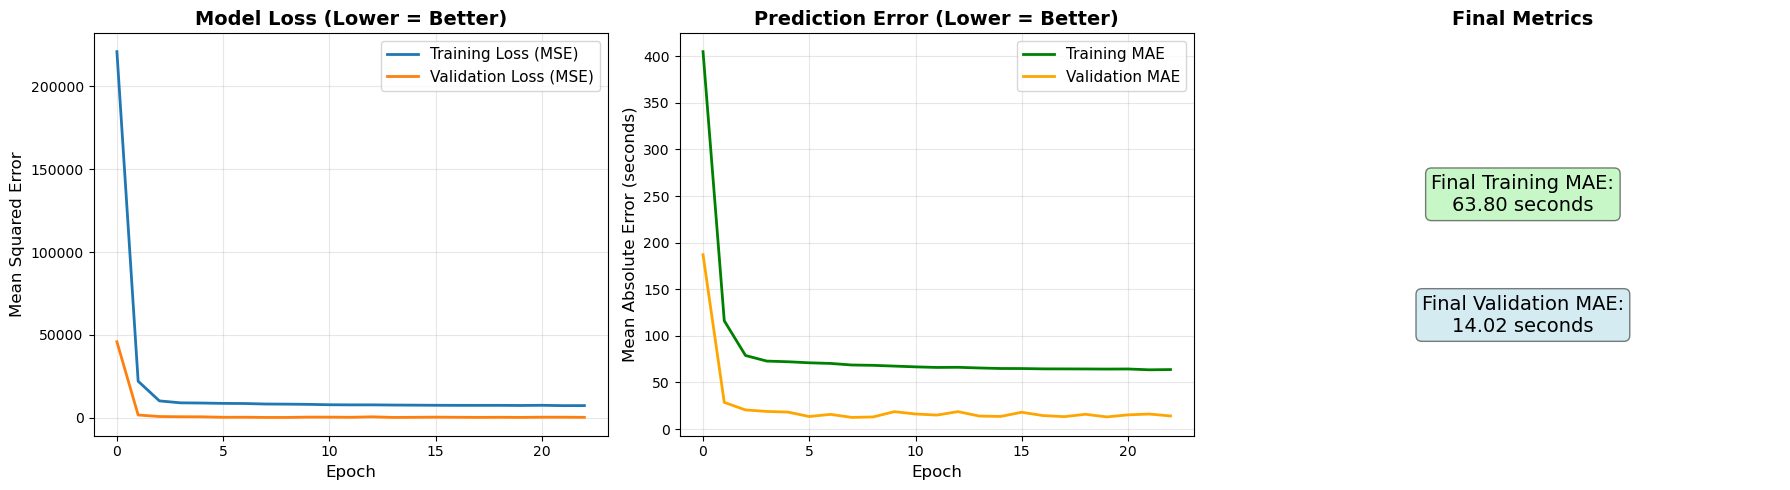


TRAINING SUMMARY
Total epochs trained: 23

Final Training MAE: 63.80 seconds
Final Validation MAE: 14.02 seconds

Best Validation MAE: 12.44 seconds

📊 Lower MAE = Better predictions!


In [71]:
def plot_history(history):
    """Plot training metrics"""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # Plot 1: Loss (MSE)
    axes[0].plot(history.history['loss'], label='Training Loss (MSE)', linewidth=2)
    axes[0].plot(history.history['val_loss'], label='Validation Loss (MSE)', linewidth=2)
    axes[0].set_xlabel('Epoch', fontsize=12)
    axes[0].set_ylabel('Mean Squared Error', fontsize=12)
    axes[0].set_title('Model Loss (Lower = Better)', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: MAE (seconds)
    axes[1].plot(history.history['mae'], label='Training MAE', linewidth=2, color='green')
    axes[1].plot(history.history['val_mae'], label='Validation MAE', linewidth=2, color='orange')
    axes[1].set_xlabel('Epoch', fontsize=12)
    axes[1].set_ylabel('Mean Absolute Error (seconds)', fontsize=12)
    axes[1].set_title('Prediction Error (Lower = Better)', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    # Plot 3: Learning Rate
    if 'lr' in history.history:
        axes[2].plot(history.history['lr'], linewidth=2, color='red')
        axes[2].set_xlabel('Epoch', fontsize=12)
        axes[2].set_ylabel('Learning Rate', fontsize=12)
        axes[2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        axes[2].set_yscale('log')
        axes[2].grid(True, alpha=0.3)
    else:
        # Show final metrics instead
        final_train_mae = history.history['mae'][-1]
        final_val_mae = history.history['val_mae'][-1]
        axes[2].text(0.5, 0.6, f"Final Training MAE:\n{final_train_mae:.2f} seconds",
                    ha='center', va='center', fontsize=14, transform=axes[2].transAxes,
                    bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
        axes[2].text(0.5, 0.3, f"Final Validation MAE:\n{final_val_mae:.2f} seconds",
                    ha='center', va='center', fontsize=14, transform=axes[2].transAxes,
                    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
        axes[2].set_title('Final Metrics', fontsize=14, fontweight='bold')
        axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n" + "="*60)
    print("TRAINING SUMMARY")
    print("="*60)
    print(f"Total epochs trained: {len(history.history['loss'])}")
    print(f"\nFinal Training MAE: {history.history['mae'][-1]:.2f} seconds")
    print(f"Final Validation MAE: {history.history['val_mae'][-1]:.2f} seconds")
    print(f"\nBest Validation MAE: {min(history.history['val_mae']):.2f} seconds")
    print("\n📊 Lower MAE = Better predictions!")
    print("="*60)

plot_history(history)

## lets evaluate the model

In [72]:
print("🔍 Evaluating on test set...\n")

# Get predictions
y_pred = model.predict(X_test_scaled, verbose=0).flatten()

# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("="*60)
print("TEST SET PERFORMANCE")
print("="*60)
print(f"Mean Absolute Error (MAE): {mae:.2f} seconds")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f} seconds")
print(f"R² Score: {r2:.4f}")
print("\n📊 Interpretation:")
print(f"   - On average, predictions are off by {mae:.1f} seconds")
print(f"   - R² of {r2:.2f} means model explains {r2*100:.1f}% of variance")
print("="*60)

🔍 Evaluating on test set...

TEST SET PERFORMANCE
Mean Absolute Error (MAE): 12.30 seconds
Root Mean Squared Error (RMSE): 16.96 seconds
R² Score: 0.9963

📊 Interpretation:
   - On average, predictions are off by 12.3 seconds
   - R² of 1.00 means model explains 99.6% of variance


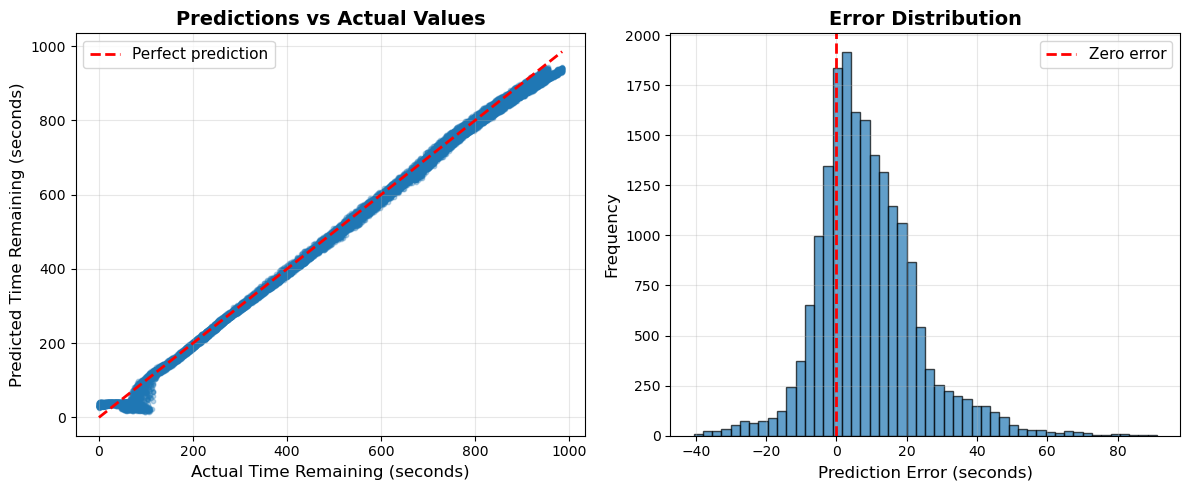


📊 Error statistics:
   Mean error: 8.90 seconds
   Std of errors: 14.44 seconds
   Median error: 9.02 seconds


In [73]:
# Plot predictions vs actual
plt.figure(figsize=(12, 5))

# Scatter plot
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.3, s=10)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect prediction')
plt.xlabel('Actual Time Remaining (seconds)', fontsize=12)
plt.ylabel('Predicted Time Remaining (seconds)', fontsize=12)
plt.title('Predictions vs Actual Values', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Error distribution
plt.subplot(1, 2, 2)
errors = y_test - y_pred
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Prediction Error (seconds)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Error Distribution', fontsize=14, fontweight='bold')
plt.axvline(0, color='r', linestyle='--', linewidth=2, label='Zero error')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Error statistics:")
print(f"   Mean error: {errors.mean():.2f} seconds")
print(f"   Std of errors: {errors.std():.2f} seconds")
print(f"   Median error: {np.median(np.abs(errors)):.2f} seconds")

## now we can create a golbal function that we can use for real time prediction

In [74]:
# Global variables for competition
current_trajectory_id = None
last_gps_data = None
last_submission_time = None

def predict_arrival_time(gps_data):
    """Predict arrival time from GPS data"""
    try:
        # Extract features in same order as training
        features = [
            gps_data['speed_kmh'],
            gps_data['distance_remaining_km'],
            gps_data['progress_percent'],
            datetime.now().hour,
            0,  # is_rush_hour
            0,  # is_weekend
            0,  # weather_encoded (sunny)
            1   # traffic_encoded (moderate)
        ]
        
        # Scale features
        features_scaled = scaler.transform([features])
        
        # Predict
        remaining_seconds = model.predict(features_scaled, verbose=0)[0][0]
        
        # Calculate arrival time
        arrival_time = datetime.now() + timedelta(seconds=float(remaining_seconds))
        
        return arrival_time
        
    except Exception as e:
        print(f"❌ Prediction error: {e}")
        return None

def submit_prediction(trajectory_id, arrival_time):
    """Submit prediction to leaderboard"""
    try:
        data = {
            'student_name': STUDENT_NAME,
            'trajectory_id': trajectory_id,
            'predicted_arrival_time': arrival_time.isoformat(),
            'timestamp': datetime.now().isoformat()
        }
        
        response = requests.post(LEADERBOARD_URL, json=data, timeout=5)
        
        if response.status_code == 200:
            print(f"✅ Submitted: {arrival_time.strftime('%H:%M:%S')}")
        else:
            print(f"⚠️ Failed: {response.status_code}")
            
    except Exception as e:
        print(f"❌ Submission error: {e}")

print("✅ Prediction functions ready")

✅ Prediction functions ready


## MQTT handler

In [75]:
def on_connect(client, userdata, flags, rc):
    """Called when connected to MQTT broker"""
    if rc == 0:
        print("✅ Connected to MQTT broker")
        client.subscribe(MQTT_TOPIC_GPS)
        client.subscribe(MQTT_TOPIC_CONTROL)
        print(f"📡 Subscribed to GPS topic")
        print(f"📡 Subscribed to Control topic")
    else:
        print(f"❌ Connection failed: {rc}")

def on_message(client, userdata, msg):
    """Called when message received"""
    global current_trajectory_id, last_gps_data, last_submission_time
    
    try:
        data = json.loads(msg.payload.decode())
        
        # Handle control messages
        if msg.topic == MQTT_TOPIC_CONTROL:
            if data.get('type') == 'ROUND_START':
                current_trajectory_id = data['trajectory_id']
                last_submission_time = None
                print(f"\n🚌 NEW ROUND: {current_trajectory_id}")
                print("="*50)
            elif data.get('type') == 'ARRIVED':
                print(f"\n🏁 ROUND COMPLETE!")
                print(f"Actual arrival: {data['actual_arrival_time']}")
                print("="*50)
            return
        
        # Handle GPS messages
        if msg.topic == MQTT_TOPIC_GPS:
            last_gps_data = data
            
            # Submit prediction every SUBMIT_INTERVAL seconds
            now = time.time()
            if last_submission_time is None or (now - last_submission_time) >= SUBMIT_INTERVAL:
                
                arrival_time = predict_arrival_time(data)
                
                if arrival_time:
                    submit_prediction(current_trajectory_id, arrival_time)
                    last_submission_time = now
                    
                    print(f"📍 {data['progress_percent']:.1f}% | "
                          f"Speed: {data['speed_kmh']} km/h | "
                          f"Remaining: {data['distance_remaining_km']:.1f} km")
                    
    except Exception as e:
        print(f"❌ Error: {e}")

print("✅ MQTT handlers configured")

✅ MQTT handlers configured


## Start competetion

In [76]:
print("="*70)
print("🏆 STARTING COMPETITION!")
print("="*70)
print(f"Student: {STUDENT_NAME}")
print(f"MQTT Broker: {MQTT_BROKER}:{MQTT_PORT}")
print(f"Leaderboard: {LEADERBOARD_URL}")
print(f"Submission interval: {SUBMIT_INTERVAL} seconds")
print(f"Model MAE: ~{history.history['val_mae'][-1]:.1f} seconds")
print("="*70)
print("\nWaiting for instructor to start rounds...")
print("Press STOP button (■) to disconnect\n")

# Create MQTT client
client = mqtt.Client(client_id=f"student_{STUDENT_NAME}")
client.on_connect = on_connect
client.on_message = on_message

try:
    client.connect(MQTT_BROKER, MQTT_PORT, 60)
    client.loop_forever()
except KeyboardInterrupt:
    print("\n👋 Disconnecting...")
    client.disconnect()
except Exception as e:
    print(f"\n❌ Error: {e}")
    print("\n💡 Checklist:")
    print("  1. Connected to AIoT_Workshop WiFi?")
    print("  2. MQTT_BROKER IP correct?")
    print("  3. Instructor started streaming?")

🏆 STARTING COMPETITION!
Student: YourName
MQTT Broker: 192.168.137.1:1883
Leaderboard: http://192.168.137.1:5000/submit_prediction
Submission interval: 30 seconds
Model MAE: ~14.0 seconds

Waiting for instructor to start rounds...
Press STOP button (■) to disconnect



C:\Users\ibaka\AppData\Local\Temp\ipykernel_21064\3773296894.py:14: DeprecationWarning: Callback API version 1 is deprecated, update to latest version
  client = mqtt.Client(client_id=f"student_{STUDENT_NAME}")



❌ Error: timed out

💡 Checklist:
  1. Connected to AIoT_Workshop WiFi?
  2. MQTT_BROKER IP correct?
  3. Instructor started streaming?


---
## 🎉 Good Luck!

**Remember:**
- Lower MAE = Better predictions
- Graphs going DOWN = Model improving
- Your model is ready to compete!

**May the best predictor win!** 🏆